In [626]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import finufft
import time
from utils.kernels import get_xis
from kernels.squared_exponential import SquaredExponential
import math
from torch.profiler import profile, record_function, ProfilerActivity
import pytorch_finufft.functional as pff
from efgp1d import efgp1d, efgp1d_NUFFT, efgp1d_gradient_batched, compute_convolution_vector_vectorized
from efgp_1d_dense import efgp1d_dense
from typing import Dict, Optional, Callable
from cg import ConjugateGradients, BatchConjugateGradients
from efgp1d import _cmplx

import pytorch_finufft.functional as pff

import warnings
warnings.filterwarnings("ignore", message=".*disabling cuda.*")


# d-dimensional GP sampler 

In [627]:


# --- Parameters ---
n = 500  # Number of points
d = 2     # Dimensionality of the input space
true_length_scale = 1
true_variance = 1
true_noise_variance = 0.1
dtype = torch.float64  # Use float64 as in the original example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
print(f"Using device: {device}")

# --- Generate Input Points ---
# Generate random points in d-dimensional space from -1 to 1
x = torch.rand(n, d, dtype=dtype, device=device) * 2 - 1

# Generate test points (grid of points for visualization if d <= 3)
if d <= 3:
    # Create a grid of points for testing
    grid_points_per_dim = 10
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
else:
    # For higher dimensions, just use random test points
    x_new = torch.rand(1000, d, dtype=dtype, device=device) * 2.4 - 1.2

# --- Define Mean and Covariance Functions (using PyTorch) ---
def mean_func_torch(x):
    """Mean function (returns zero vector)."""
    # Make sure output shape matches input batch shape if any
    return torch.zeros(x.shape[0], dtype=x.dtype, device=x.device)

# Squared Exponential Kernel Function for d-dimensional inputs
def squared_exponential_kernel(x1, x2, length_scale=1.0, variance=1.0):
    """
    Squared Exponential kernel using PyTorch.
    Calculates variance * exp(-0.5 * ||x1 - x2||^2 / length_scale^2)
    Handles multi-dimensional (n, d) inputs.
    """
    # Compute pairwise squared Euclidean distances
    # dist_sq = ||a - b||^2 = ||a||^2 - 2a^T b + ||b||^2
    sum_sq_x1 = torch.sum(x1**2, dim=1, keepdim=True)  # Shape (n, 1)
    sum_sq_x2 = torch.sum(x2**2, dim=1)                # Shape (m,)
    cross_term = torch.matmul(x1, x2.T)                # Shape (n, m)

    # sq_dist shape: (n, 1) + (m,) - 2 * (n, m) -> broadcasting -> (n, m)
    sq_dist = sum_sq_x1 + sum_sq_x2 - 2 * cross_term

    # Ensure squared distances are non-negative (due to potential floating point inaccuracies)
    sq_dist = torch.clamp(sq_dist, min=0.0)

    # Compute the Squared Exponential kernel
    cov = variance * torch.exp(-0.5 * sq_dist / length_scale**2)
    return cov

# --- Optimized Sampling Function ---
def sample_gp_fast(x, mean_func, cov_func, num_samples, length_scale, variance, noise_variance):
    """
    Samples efficiently from a d-dimensional Gaussian Process by pre-computing
    the Cholesky decomposition of the noisy covariance matrix.

    Parameters:
    x : torch.Tensor (n, d)
        Input points in d-dimensional space.
    mean_func : callable
        Mean function.
    cov_func : callable
        Covariance function (kernel).
    num_samples : int
        Number of samples to draw.
    length_scale : float
        Kernel length scale.
    variance : float
        Kernel variance.
    noise_variance : float
        Variance of the observation noise.

    Returns:
    torch.Tensor (n, num_samples)
        Samples from the GP at the input points x.
    """
    n_points = x.shape[0]
    mean = mean_func(x)  # Shape (n_points,)

    # 1. Compute Covariance Matrix K
    K = cov_func(x, x, length_scale=length_scale, variance=variance)  # (n_points, n_points)

    # 2. Add Noise Variance to Diagonal
    K_noisy = K + noise_variance * torch.eye(n_points, dtype=x.dtype, device=x.device)

    # 3. Compute Cholesky Factor L (K_noisy = L L^T)
    try:
        L = torch.linalg.cholesky(K_noisy)  # (n_points, n_points), lower triangular
    except torch.linalg.LinAlgError as e:
        print(f"Cholesky decomposition failed: {e}")
        # Fallback with jitter
        jitter = 1e-6 * torch.eye(n_points, dtype=x.dtype, device=x.device)
        try:
            L = torch.linalg.cholesky(K_noisy + jitter)
            print("Cholesky succeeded after adding jitter.")
        except torch.linalg.LinAlgError as e2:
            print(f"Cholesky decomposition failed even with jitter: {e2}")
            raise RuntimeError("Could not compute Cholesky decomposition.") from e2

    # 4. Efficient Sampling
    # Draw standard normal samples Z ~ N(0, I)
    Z = torch.randn(n_points, num_samples, dtype=x.dtype, device=x.device)  # (n_points, num_samples)

    # Compute samples: Y = mean + L @ Z
    samples = mean.unsqueeze(1) + L @ Z  # (n_points, num_samples)

    return samples

# --- Generate Samples ---
print(f"Generating {1} sample for n={n} points in {d} dimensions...")
start_time = time.time()

# Sample using the optimized function
y = sample_gp_fast(
    x,
    mean_func_torch,
    squared_exponential_kernel,
    num_samples=1,
    length_scale=true_length_scale,
    variance=true_variance,
    noise_variance=true_noise_variance
).flatten()

end_time = time.time()
print(f"Generated sample of size {y.shape[0]}.")
print(f"Time taken: {end_time - start_time:.4f} seconds")


Using device: cpu
Generating 1 sample for n=500 points in 2 dimensions...
Generated sample of size 500.
Time taken: 0.0027 seconds


In [628]:
sigmasq = torch.tensor([0.1])

Plotting the generated Gaussian Process data...


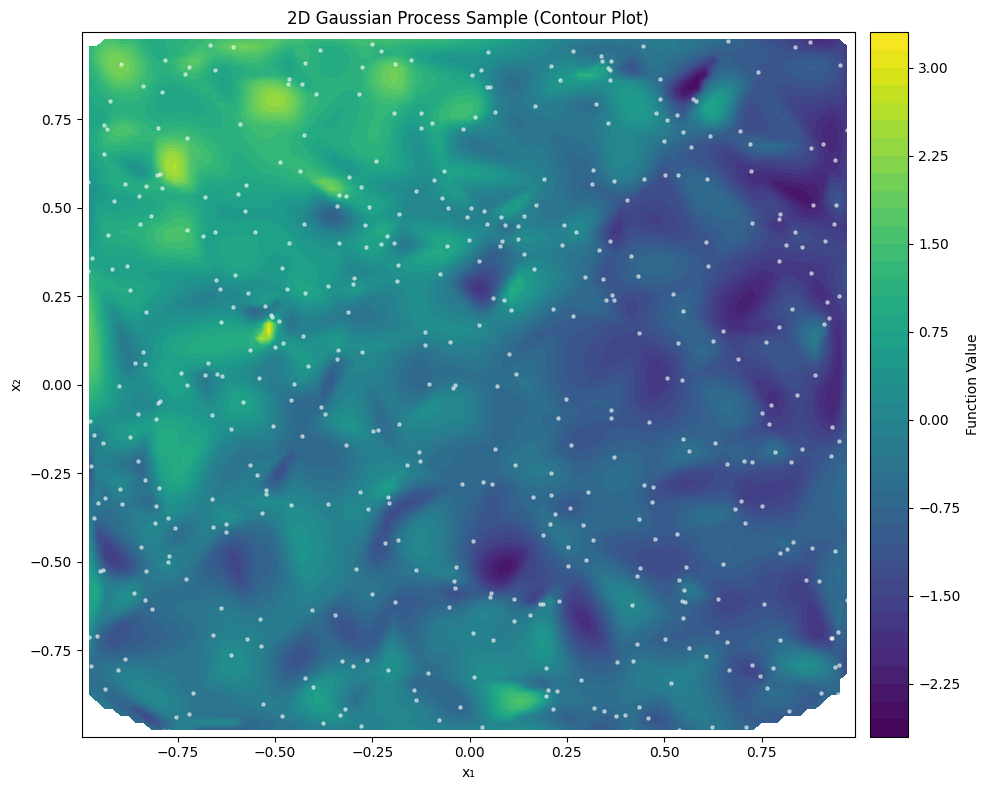

In [629]:
# --- Plot the Generated Data ---
print("Plotting the generated Gaussian Process data...")

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import griddata

# Determine the dimensionality of the data
d = x.shape[1]

if d == 1:
    # 1D plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x.cpu().numpy(), y.cpu().numpy(), alpha=0.7, s=10)
    plt.title('1D Gaussian Process Sample')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()

elif d == 2:
    # 2D contour plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 8), gridspec_kw={'width_ratios': [1, 0.05]})
    
    # Extract coordinates
    x1, x2 = x[:, 0].cpu().numpy(), x[:, 1].cpu().numpy()
    y_values = y.cpu().numpy()
    
    # Create a regular grid for interpolation
    grid_size = 100
    x1_grid = np.linspace(x1.min(), x1.max(), grid_size)
    x2_grid = np.linspace(x2.min(), x2.max(), grid_size)
    X1, X2 = np.meshgrid(x1_grid, x2_grid)
    
    # Interpolate the scattered data onto the regular grid
    Y_grid = griddata((x1, x2), y_values, (X1, X2), method='cubic')
    
    # Create contour plot
    contour = ax[0].contourf(X1, X2, Y_grid, 50, cmap='viridis')
    ax[0].scatter(x1, x2, c='white', s=5, alpha=0.5)
    ax[0].set_title('2D Gaussian Process Sample (Contour Plot)')
    ax[0].set_xlabel('x₁')
    ax[0].set_ylabel('x₂')
    
    # Add colorbar
    plt.colorbar(contour, cax=ax[1], label='Function Value')
    
    plt.tight_layout()
    plt.show()

elif d == 3:
    # 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract coordinates
    x1, x2, x3 = x[:, 0].cpu().numpy(), x[:, 1].cpu().numpy(), x[:, 2].cpu().numpy()
    y_values = y.cpu().numpy()
    
    # Create scatter plot with color representing the function value
    scatter = ax.scatter(
        x1, x2, x3, 
        c=y_values, 
        cmap='viridis', 
        s=30, 
        alpha=0.8
    )
    
    plt.colorbar(scatter, ax=ax, label='Function Value')
    ax.set_title('3D Gaussian Process Sample')
    ax.set_xlabel('x₁')
    ax.set_ylabel('x₂')
    ax.set_zlabel('x₃')
    plt.tight_layout()
    plt.show()

else:
    print(f"Cannot visualize data in {d} dimensions directly.")
    
    # For higher dimensions, we can show pairwise relationships
    if d > 3:
        print("Showing pairwise relationships for the first 3 dimensions:")
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        
        # Plot first 3 dimensions against the function value
        for i in range(min(3, d)):
            scatter = axs[i].scatter(
                x[:, i].cpu().numpy(), 
                y.cpu().numpy(), 
                alpha=0.7, 
                s=10, 
                c=y.cpu().numpy(), 
                cmap='viridis'
            )
            axs[i].set_xlabel(f'x_{i+1}')
            axs[i].set_ylabel('Function Value')
            axs[i].grid(True)
            
        plt.colorbar(scatter, ax=axs)
        plt.tight_layout()
        plt.show()


In [630]:

kernel = SquaredExponential(dimension=d, lengthscale=torch.tensor([true_length_scale]), variance=torch.tensor(true_variance))
init_kernel = kernel
# kernel = SquaredExponential(dimension=1, lengthscale=torch.tensor([0.5*1e-2]), variance=torch.tensor(1.0))


In [631]:
kernel

SquaredExponential(dimension=2, lengthscale=1.0, variance=1.0)

# Making tensor product grid of xis 

In [632]:
# Determine problem geometry
# max and min of each dimension
# updated L according to how it's calculated in philip's code
x0 = x.min(dim=0).values  
x1 = x.max(dim=0).values  

domain_lengths = x1 - x0
L = domain_lengths.max()
N = x.shape[0]
EPSILON = 1e-4
xis_1d, h, mtot = get_xis(kernel_obj=kernel, eps=EPSILON, L=L, use_integral=False, l2scaled=False)
print(xis_1d.shape)
grids = torch.meshgrid(*(xis_1d for _ in range(d)), indexing='ij') # makes tensor product Jm 
xis = torch.stack(grids, dim=-1).view(-1, d) 
print(xis.shape)
ws = torch.sqrt(kernel.spectral_density(xis).to(dtype=torch.complex128) * h**d) # (mtot**d,1)


torch.Size([15])
torch.Size([225, 2])


In [633]:
D = torch.diag(ws).to(dtype=torch.complex128) # (mtot**d, mtot**d)


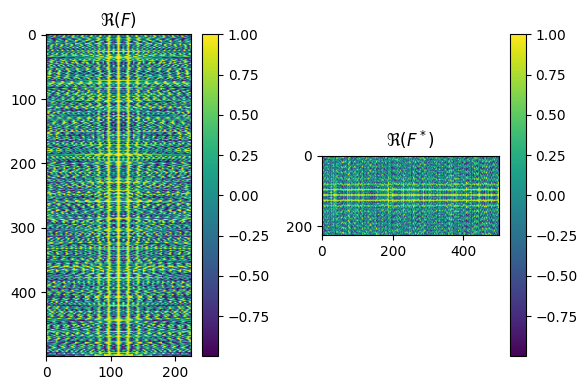

In [634]:

# Form design matrix F
# We do so manually here for clarity (no FFT / NUFFT) x @ j.t()  
F = torch.exp(1j * 2 * torch.pi * (x @ xis.T))
# F = torch.exp(1j * 2 * torch.pi * (x@xis.t()).to(dtype=torch.complex128))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))

im1 = ax1.imshow(F.real)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r'$\Re(F)$')

im2 = ax2.imshow(F.conj().T.real)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r'$\Re(F^*)$')

plt.tight_layout()
plt.show()

# ws_diag = torch.diag(ws).to(dtype=Phi.dtype) # complex dtype
# A = ws_diag @ (Phi.T @ Phi) @ ws_diag



In [635]:
# get kernel matrix using kernel.kernel_matrix
kernel_matrix = kernel.kernel_matrix(x, x)


In [636]:
ws = ws.to(dtype=torch.complex128)
F = F.to(dtype=torch.complex128)
A = D @ (torch.conj(F).T @ F) @ D
kernel_approx =  ((F @ torch.diag(ws)) @ (torch.diag(ws) @ torch.conj(F).T))

Kernel matrix and kernel approx are close at 0.0001


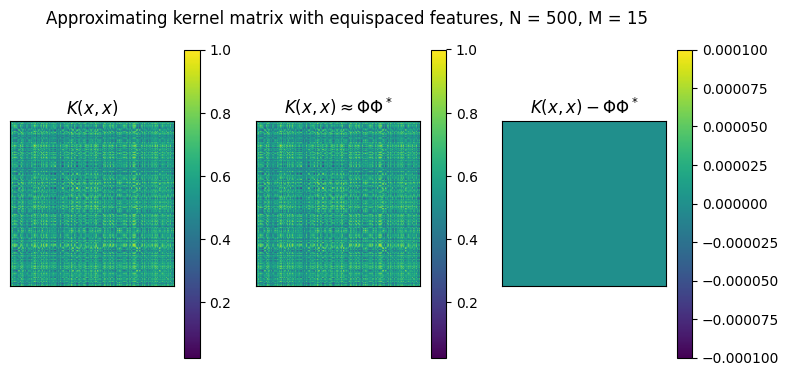

In [637]:
# subplot kernel matrix, kernel approx, and difference side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 4))

im1 = ax1.imshow(kernel_matrix)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r'$K(x, x)$')
# no axis labels
ax1.set_xticks([])
ax1.set_yticks([])

im2 = ax2.imshow(kernel_approx.real)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r'$K(x, x) \approx \Phi \Phi^*$')
ax2.set_xticks([])
ax2.set_yticks([])

diff = kernel_matrix - kernel_approx.real
im3 = ax3.imshow(diff)
plt.colorbar(im3, ax=ax3)
ax3.set_title(r'$K(x, x) - \Phi \Phi^*$')
ax3.set_xticks([])
ax3.set_yticks([])

plt.suptitle(f'Approximating kernel matrix with equispaced features, N = {N}, M = {mtot}')
# Get the maximum absolute value in the difference matrix for colorbar limits
# Set the color limits to be symmetric around zero, bounded by epsilon
im3.set_clim(-EPSILON, EPSILON)

assert torch.allclose(kernel_matrix, kernel_approx.real, atol=EPSILON)
print(f"Kernel matrix and kernel approx are close at {EPSILON}")



In [638]:
import math
import torch
import pytorch_finufft.functional as pff

# ─────────── Inputs (already defined) ────────────────────────────────────
# x      : torch.Tensor of shape (N, d)   — real training locations
# y      : torch.Tensor of shape (N,)     — real training targets
# kernel : object with kernel.spectral_density(xis) method
# EPSILON: float, quadrature tolerance
# ────────────────────────────────────────────────────────────────────────

device = x.device
rdtype = torch.float64
cdtype = torch.complex128
OUT    = (mtot,) * d                     # NUFFT output shape

# 1) Cast to double and move to device
x = x.to(device, rdtype)
y = y.to(device, rdtype)

N, d = x.shape

# 2) Single‐dimensional quadrature (shared across dims)
#    Use the maximal span among the d coordinates
span   = (x.max(dim=0).values - x.min(dim=0).values).max().item()

xcen = torch.zeros(d, device=device, dtype=rdtype)
phi  = 2 * math.pi * h * (x - xcen)     # (N, d)
phi  = phi.T.contiguous()               # (d, N) for finufft

# 5) NUFFT wrappers (torch‑native, CMCL order)
nufft_eps = 1e-15

def finufft1(vals):
    """
    Adjoint NUFFT: nonuniform→uniform.
    vals: (N,) complex
    returns: tensor of shape OUT, then flattened
    """
    arr = pff.finufft_type1(
        phi, vals.to(cdtype), OUT,
        eps=nufft_eps, isign=-1, modeord=False
    )
    return arr.reshape(-1)  # (mtot**d,)

def finufft2(fk_flat):
    """
    Forward NUFFT: uniform→nonuniform.
    fk_flat: (mtot**d,) complex, in CMCL order
    returns: tensor of shape (N,)
    """
    fk_nd = fk_flat.reshape(OUT)
    return pff.finufft_type2(
        phi, fk_nd.to(cdtype),
        eps=nufft_eps, isign=+1, modeord=False
    )

# 6) Sanity checks:

# (a)  F* y  via NUFFT
fadj_y_nufft = finufft1(y)
fadj_y_nufft_ref = F.conj().T@y.to(dtype=torch.complex128)

# (b)  F  ws_nd  via NUFFT
f_ws_nufft  = finufft2(ws)

f_ws_nufft_ref = F@ws

torch.allclose(fadj_y_nufft, fadj_y_nufft_ref)
torch.allclose(f_ws_nufft, f_ws_nufft_ref)
print(f"Multi‑D NUFFT adjoint/forward check passed for OUT={OUT}")


Multi‑D NUFFT adjoint/forward check passed for OUT=(15, 15)


In [639]:
def efgp1d_NUFFT(x: torch.Tensor, y: torch.Tensor, sigmasq: float,
                 kernel: dict, eps: float, x_new: torch.Tensor,
                 do_profiling: bool = True, opts: Optional[dict] = None):

    activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA] if do_profiling else []
    with profile(activities=activities, record_shapes=True) as prof:

        # ---------- casts ---------------------------------------------------
        device = x.device
        dtype = torch.float64 # Use float64 as in the original example
        rdtype = torch.float64
        cdtype = _cmplx(rdtype)

        x = x.to(dtype=rdtype)
        y = y.to(dtype=rdtype)
        x_new = x_new.to(dtype=rdtype)

        # ---------- geometry -----------------------------------------------
        x0, x1 = torch.min(torch.cat([x, x_new])), torch.max(torch.cat([x, x_new]))
        L = x1 - x0
        N = x.shape[0]

        # ---------- quadrature ---------------------------------------------
        xis, h, mtot = get_xis(kernel, eps, L.item())
        xis = xis.to(device)
        ws  = torch.sqrt(kernel.spectral_density(xis).to(cdtype) * h)  # (M,)
        M   = mtot

        # ---------- NUFFT wrappers (CMCL order) ----------------------------
        OUT = (M,)
        nufft_eps = 1e-15

        def finufft1(phi, vals):
            return pff.finufft_type1(phi.unsqueeze(0), vals.to(cdtype), OUT,
                                     eps=nufft_eps, isign=-1, modeord=False)

        def finufft2(phi, fk):
            return pff.finufft_type2(phi.unsqueeze(0), fk.to(cdtype),
                                     eps=nufft_eps, isign=+1, modeord=False)
        
        phi = (2 * math.pi * h * (x - 0.0)).to(rdtype)
        fadj = lambda v: finufft1(phi, v)          # NU → U

        # ---------- RHS -----------------------------------------------------
        with record_function("right_hand_side"):
            right_hand_side = ws * fadj(y)

        # ---------- Toeplitz kernel & operator -----------------------------
        with record_function("convolution_vector"):
            v_kernel = compute_convolution_vector_vectorized(
                m=int((mtot - 1) / 2), x=x, h=h).to(cdtype)

        toeplitz = Toeplitz1D(v_kernel)

        def A_apply(beta):
            return ws * toeplitz(ws * beta) + sigmasq * beta

        # ---------- CG solve ------------------------------------------------
        cg_object = ConjugateGradients(A_apply, b=right_hand_side,
                                       x0=torch.zeros_like(right_hand_side),
                                       early_stopping=False)
        with record_function("solve"):
            beta = cg_object.solve()

        # ---------- posterior predictive mean ------------------------------
        with record_function("posterior_predictive_mean"):
            phi_new = (2 * math.pi * h * (x_new - 0.0)).to(rdtype)
            yhat = finufft2(phi_new, ws * beta).real

        ytrg = {'mean': yhat}

            ### Variance calculation


        # (F* F/sigmasq + I/ws**2)
        def C_apply(beta):
            return ws* toeplitz(ws*beta)/sigmasq +  beta
        
        
        
        m  = (mtot - 1) // 2
        k  = torch.cat((
                torch.arange(-m, 0,  device=device, dtype=dtype),  # -m,…,-1
                torch.arange( 0, m+1, device=device, dtype=dtype)   #  0,…, m
        ))              
        # form batches of f_x
        # def f_x_batch(x_batch: torch.Tensor, h: float) -> torch.Tensor:
        #     """
        #     x_batch : (B,)  real
        #     Returns  : (B, M) complex   with CMCL ordering
        #     """
        phase = 1j * 2 * math.pi * h * x_new[:, None] * k[None, :]   # (B,M)
        f_x = torch.exp(phase) 
        # Compute f_x for the batch of test points
        # f_x = f_x_batch(x_new, h)  # (B,M) complex
        
        # Initialize BatchConjugateGradients to solve C^{-1} f_x 
        batch_cg = BatchConjugateGradients(
            C_apply, 
            ws*f_x.conj(), 
            torch.zeros_like(f_x.conj()),
            tol=1e-6, 
            early_stopping=False
        )
        ### End Variance calculation
        
        # Solve the system for all points in the batch simultaneously
        C_inv_f_x = ws *batch_cg.solve()  # (B,M) complex
        
        s2 = torch.real((f_x * C_inv_f_x).sum(dim=1))    # (B,)
        ytrg['var'] = s2

        if opts is not None and opts.get('get_log_marginal_likelihood', False):
            ytrg['log_marginal_likelihood'] = None  # TODO

    # ---------- profiler summary -------------------------------------------
    # print("\nProfiler Results Summary:")
    # print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=50))

    return beta, xis, ytrg

In [640]:
import torch, math
m = mtot//2 -1 
def compute_convolution_vector_vectorized_dD(m: int, x: torch.Tensor, h: float) -> torch.Tensor:
    """
    Multi‑D type‑1 NUFFT convolution vector:
      v[k1,...,kd] = sum_n exp(2πi <k, x_n>)
    """
    device      = x.device
    dtype_real  = x.dtype
    dtype_cmplx = torch.complex64 if dtype_real == torch.float32 else torch.complex128
    if x.ndim == 1:
        x = x[:, None]
    N, d        = x.shape
    eps         = 1e-15

    # (d, N) array of phases
    phi = (2 * math.pi * h * x).T.contiguous().to(dtype_real)

    # all weights = 1 + 0i
    c = torch.ones(N, dtype=dtype_cmplx, device=device)

    # output grid size in each of the d dims
    OUT = tuple([4*m + 1] * d)

    v = pff.finufft_type1(
        phi,    # (d, N)
        c,      # (N,)
        OUT,
        eps=eps,
        isign=-1,
        modeord=False
    )
    return v


In [641]:
m

6

In [642]:
# compute exp(2pi i <xi, x>)
ks = torch.stack(torch.meshgrid(*([torch.arange(-2*m,2*m+1) for _ in range(d)]), indexing='ij'), dim=-1).reshape(-1, d)
vtest = compute_convolution_vector_vectorized_dD(m,x,h)

v_true = torch.exp(-2*math.pi*1j* (x @ (h*ks).T)).sum(dim=0)
assert torch.allclose(vtest.flatten(), v_true, atol=1e-4)

In [643]:
import torch
import torch.nn.functional as nnf
from math import prod

class ToeplitzND:
    """
    Fast d‑dimensional block‑Toeplitz convolution via FFT.
    Caches the FFT of a fixed kernel and then performs
    conv with any flat-or-block input.

    Args:
      v: complex tensor of shape (L1,...,Ld) with Li = 2*ni - 1
      force_pow2: zero‑pad each dim to next power‑of‑2

    Call with x either:
      • flat: 1D tensor of length prod(ni), or
      • block: tensor whose last d dims are exactly (n1,...,nd)
    """
    def __init__(self, v: torch.Tensor, *, force_pow2: bool = True):
        # ensure complex
        if not v.is_complex():
            v = v.to(torch.complex128)
        self.device = v.device

        # dims and block‑sizes
        self.Ls   = list(v.shape)                   # [L1,...,Ld]
        self.ns   = [(L+1)//2 for L in self.Ls]     # [n1,...,nd]
        self.size = prod(self.ns)                   # total block elements

        # fft grid
        if force_pow2:
            self.fft_shape = [1 << (L-1).bit_length() for L in self.Ls]
        else:
            self.fft_shape = self.Ls.copy()

        # pad & cache kernel FFT
        pad = []
        for L, F in zip(reversed(self.Ls), reversed(self.fft_shape)):
            pad += [0, F - L]
        v_pad     = nnf.pad(v.to(self.device), pad)
        self.fft_v = torch.fft.fftn(v_pad, s=self.fft_shape,
                                    dim=list(range(-len(self.Ls), 0)))

        # slice indices for central block
        self.starts = [n-1 for n in self.ns]
        self.ends   = [st+n for st, n in zip(self.starts, self.ns)]

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        x = x.to(self.device)
        flat = False

        # detect flat vs block
        if x.ndim == 1 and x.numel() == self.size:
            flat = True
            x = x.view(*self.ns)
        elif x.ndim >= len(self.ns) and list(x.shape[-len(self.ns):]) == self.ns:
            flat = False
        else:
            raise AssertionError(
                f"Expected flat length {self.size} or block shape {*self.ns,}, got {tuple(x.shape)}"
            )

        # ensure complex
        if not x.is_complex():
            x = x.to(torch.complex128)

        # pad x → fft grid
        pad = []
        for n, F in zip(reversed(self.ns), reversed(self.fft_shape)):
            pad += [0, F - n]
        x_pad = nnf.pad(x, pad)

        # FFT conv
        y  = torch.fft.ifftn(self.fft_v * torch.fft.fftn(x_pad, s=self.fft_shape,
                                                        dim=list(range(-len(self.ns), 0))),
                             s=self.fft_shape,
                             dim=list(range(-len(self.ns), 0)))

        # slice central block
        slices = [slice(None)]*(y.ndim - len(self.ns))
        for st, en in zip(self.starts, self.ends):
            slices.append(slice(st, en))
        y = y[tuple(slices)]

        return y.flatten() if flat else y


In [644]:
m    = (mtot - 1)//2  
vtest = compute_convolution_vector_vectorized_dD(m, x, h)
toeplitz2d = ToeplitzND(vtest)
beta_flat = torch.ones(mtot**d, dtype=torch.complex128, device=device)
out_flat  = toeplitz2d(beta_flat)    

In [645]:
assert torch.allclose(toeplitz2d(beta_flat), (F.conj().T@F)@ beta_flat)
print(f"ToeplitzND agrees with matrix multiplication")

ToeplitzND agrees with matrix multiplication


In [646]:
import math
import torch
import torch.nn.functional as nnf
from typing import Optional, Tuple, List, Dict, Union
from math import prod

# Assume these helper functions/classes are defined elsewhere or imported
# from your project structure.
# Need: get_xis, ConjugateGradients, BatchConjugateGradients,
#       compute_convolution_vector_vectorized_dD, ToeplitzND, _cmplx,
#       ProfilerActivity, profile, record_function

# --- Placeholders (Ensure these are replaced with actual implementations) ---
# Placeholder for complex type helper
def _cmplx(dtype: torch.dtype) -> torch.dtype:
    """Maps float dtype to corresponding complex dtype."""
    if dtype == torch.float32: return torch.complex64
    if dtype == torch.float64: return torch.complex128
    raise ValueError(f"Unsupported dtype: {dtype}")


# --- The Multi-D EFGP Function ---

def efgp_nd(x: torch.Tensor, y: torch.Tensor, sigmasq: float,
            kernel: object, # Assume object with kernel.spectral_density(xis)
            eps: float,
            x_new: torch.Tensor,
            do_profiling: bool = True,
            opts: Optional[dict] = None) -> Tuple[torch.Tensor, torch.Tensor, Dict[str, torch.Tensor]]:
    """
    Efficient Gaussian Process Regression for N-Dimensional data using NUFFT.
    (Incorporates fix for ToeplitzND batch input)
    """
    if opts is None: opts = {}

    activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA] if do_profiling and torch.cuda.is_available() else [ProfilerActivity.CPU]
    with profile(activities=activities, record_shapes=True) as prof:

        # ---------- Casts and Device -----------------------------------------
        device = x.device
        rdtype = torch.float64
        cdtype = _cmplx(rdtype)

        x = x.to(device, rdtype); y = y.to(device, rdtype)
        x_new = x_new.to(device, rdtype)
        sigmasq = torch.tensor(sigmasq, device=device, dtype=rdtype)

        N, d = x.shape; B = x_new.shape[0]
        if x_new.shape[1] != d: raise ValueError(f"Dim mismatch: x ({d}) vs x_new ({x_new.shape[1]})")

        # ---------- Geometry -------------------------------------------------
        x_all = torch.cat([x, x_new], dim=0)
        x0 = x_all.min(dim=0).values; x1 = x_all.max(dim=0).values
        domain_lengths = x1 - x0
        L = domain_lengths.max()
        if L <= 1e-9: L = torch.tensor(1.0, device=device, dtype=rdtype)
        L_item = L.item()

        # ---------- Quadrature -----------------------------------------------
        with record_function("quadrature"):
            xis_1d, h_float, mtot = get_xis(kernel_obj=kernel, eps=eps, L=L_item,
                                             use_integral=False, l2scaled=False)
            xis_1d = xis_1d.to(device, rdtype)
            h = torch.tensor(h_float, device=device, dtype=rdtype)

            grids = torch.meshgrid(*(xis_1d for _ in range(d)), indexing='ij')
            xis = torch.stack(grids, dim=-1).view(-1, d) # Shape (M, d), M = mtot**d
            M = xis.shape[0]

            spectral_vals = kernel.spectral_density(xis).to(cdtype)
            if spectral_vals.shape != (M,): raise ValueError(f"Spectral density shape mismatch")
            ws = torch.sqrt(spectral_vals * (h**d)) # Shape (M,)

        # ---------- NUFFT Setup ----------------------------------------------
        with record_function("nufft_setup"):
            OUT = (mtot,) * d
            nufft_eps = 1e-15
            xcen = torch.zeros(d, device=device, dtype=rdtype) # Or (x0+x1)/2
            phi_train = (2 * math.pi * h * (x - xcen)).T.contiguous() # (d, N)
            phi_test = (2 * math.pi * h * (x_new - xcen)).T.contiguous() # (d, B)

            def finufft1(phi_in, vals): # NU -> U
                arr = pff.finufft_type1(phi_in, vals.to(cdtype), OUT, eps=nufft_eps, isign=-1, modeord=False)
                return arr.reshape(-1) # Flatten to (M,)

            def finufft2(phi_in, fk_flat): # U -> NU
                fk_nd = fk_flat.reshape(OUT).to(cdtype)
                return pff.finufft_type2(phi_in, fk_nd, eps=nufft_eps, isign=+1, modeord=False)

        # ---------- RHS for Mean Calculation --------------------------------
        with record_function("rhs_mean"):
            fadj_y = finufft1(phi_train, y) # Shape (M,)
            right_hand_side = ws * fadj_y # Shape (M,)

        # ---------- Toeplitz Kernel & Operator Setup ------------------------
        with record_function("toeplitz_setup"):
            m_conv = (mtot - 1) // 2
            v_kernel = compute_convolution_vector_vectorized_dD(m_conv, x, h).to(cdtype)
            expected_v_shape = (2*mtot - 1,) * d
            if v_kernel.shape != expected_v_shape: raise ValueError(f"Conv vector shape mismatch")

            toeplitz = ToeplitzND(v_kernel, force_pow2=True)
            # Extract grid shape ns = [mtot, mtot, ...] from toeplitz object
            ns_shape = tuple(toeplitz.ns)
            if prod(ns_shape) != M:
                raise ValueError(f"Toeplitz grid size {prod(ns_shape)} doesn't match M={M}")

            # --- Define Operators A and C with Batch Handling ---

            # Reshape ws once for broadcasting: (M,) -> (1, n1, n2, ...)
            ws_block_view = ws.view(1, *ns_shape)

            def A_apply(beta_in: torch.Tensor) -> torch.Tensor:
                """Applies W T W + sigmasq I. Handles flat (M,) or batch (B, M) input."""
                is_batch = beta_in.ndim > 1
                input_shape = beta_in.shape
                if not beta_in.is_complex(): beta_in = beta_in.to(cdtype)

                if is_batch: # Input (B, M)
                    B_dim = input_shape[0]
                    # Reshape input: (B, M) -> (B, n1, n2, ...)
                    beta_in_block = beta_in.view(B_dim, *ns_shape)
                    # Apply ops using broadcasting for ws
                    w_beta_block = ws_block_view * beta_in_block # (1,n...) * (B,n...) -> (B,n...)
                    T_W_beta_block = toeplitz(w_beta_block) # Input (B,n...), Output (B,n...)
                    result_block = ws_block_view * T_W_beta_block
                    # Reshape back: (B, n1, n2, ...) -> (B, M)
                    result_flat = result_block.view(B_dim, M)
                    # Add noise term (beta_in is already (B,M))
                    return result_flat + sigmasq * beta_in
                else: # Input (M,) - Flat case for mean CG
                    # Reshape input: (M,) -> (n1, n2, ...) for Toeplitz block input if needed
                    # Or rely on ToeplitzND to handle flat input correctly. Let's assume it does.
                    w_beta_flat = ws * beta_in # (M,)
                    T_W_beta_flat = toeplitz(w_beta_flat) # Input (M,), Output (M,)
                    result_flat = ws * T_W_beta_flat
                    return result_flat + sigmasq * beta_in


            def C_apply(gamma_in: torch.Tensor) -> torch.Tensor:
                """Applies W T W / sigmasq + I. Expects batch (B, M) input."""
                # Assume input is always batch (B, M) from BatchCG
                B_dim = gamma_in.shape[0]
                if not gamma_in.is_complex(): gamma_in = gamma_in.to(cdtype)

                # Reshape input: (B, M) -> (B, n1, n2, ...)
                gamma_in_block = gamma_in.view(B_dim, *ns_shape)

                # Apply ops using broadcasting for ws
                w_gamma_block = ws_block_view * gamma_in_block
                T_W_gamma_block = toeplitz(w_gamma_block) # Input (B,n...), Output (B,n...)
                result_block = ws_block_view * T_W_gamma_block / sigmasq

                # Reshape back: (B, n1, n2, ...) -> (B, M)
                result_flat = result_block.view(B_dim, M)

                # Add identity term (gamma_in is already (B, M))
                return result_flat + gamma_in

        # ---------- CG Solve for Mean ---------------------------------------
        with record_function("cg_solve_mean"):
            cg_object = ConjugateGradients(A_apply, b=right_hand_side,
                                           x0=torch.zeros_like(right_hand_side),
                                           tol=1e-10, early_stopping=False)
            beta = cg_object.solve() # Shape (M,) complex

        # ---------- Posterior Predictive Mean -------------------------------
        with record_function("predict_mean"):
            yhat = finufft2(phi_test, ws * beta).real # Shape (B,)
        ytrg = {'mean': yhat}

        # ---------- Posterior Predictive Variance ---------------------------
        with record_function("predict_variance"):
            # Calculate Fourier features f_x = exp(2 pi i <x_new, xi>) (B, M)
            f_x = torch.exp(2 * math.pi * 1j * torch.matmul(x_new, xis.T))

            # RHS for variance CG: W f_x^* (B, M)
            rhs_var_batch = ws.unsqueeze(0) * f_x.conj() # Add batch dim to ws for broadcast

            # Solve C gamma = rhs_var_batch using Batch CG
            batch_cg = BatchConjugateGradients(
                C_apply, # Operator C expects (B, M) input now
                rhs_var_batch, # Batched RHS (B, M)
                torch.zeros_like(rhs_var_batch), # Initial guess (B, M)
                tol=1e-10, early_stopping=False
            )
            gamma = batch_cg.solve() # Shape (B, M) complex

            # Compute variance: s2 = Re[ (f_x * (ws * gamma)).sum(dim=1) ]
            # ws is (M,), gamma is (B, M). Need broadcasting.
            s2 = torch.real((f_x * (ws.unsqueeze(0) * gamma)).sum(dim=-1)) # Shape (B,)
            s2 = torch.clamp(s2, min=0.0) # Ensure non-negative
            ytrg['var'] = s2

        # ---------- Log Marginal Likelihood (Optional) ----------------------
        if opts.get('get_log_marginal_likelihood', False):
            print("Warning: Log Marginal Likelihood not implemented.")
            ytrg['log_marginal_likelihood'] = None

    # ---------- Profiler Summary -------------------------------------------
    # if do_profiling and prof is not None:
    #     try:
    #         print("\nProfiler Results Summary:")
    #         # Using self_cpu_time_total might be more informative for CPU-bound parts
    #         print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=20))
    #     except AttributeError:
    #          print("Could not display profiler results (possibly due to placeholder).")


    return beta, xis, ytrg, ws 



In [647]:
beta, xis , ytrg ,ws = efgp_nd(x=x,y=y,sigmasq=sigmasq,kernel=kernel,eps=EPSILON,x_new= x_new,opts=None)

/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_97231/2233841875.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [648]:
import torch
import math

N, d = x.shape
B = x_new.shape[0]
M = xis.shape[0]

x = x.to(device, rdtype)
y = y.to(device, rdtype)
x_new = x_new.to(device, rdtype)
xis = xis.to(device, rdtype)
ws = ws.to(device, cdtype)
sigmasq = torch.tensor(sigmasq, device=device, dtype=rdtype)

F_train = torch.exp(2 * math.pi * 1j * torch.matmul(x, xis.T)).to(cdtype)
F_new = torch.exp(2 * math.pi * 1j * torch.matmul(x_new, xis.T)).to(cdtype)

W_F_train_star = ws.unsqueeze(1) * F_train.conj().T

K_train = (F_train * ws) @ W_F_train_star
K_new_train = (F_new * ws) @ W_F_train_star
diag_K_new_new = torch.sum(torch.abs(F_new * ws)**2, dim=1)

I_N = torch.eye(N, device=device, dtype=rdtype)
K_plus_noise = K_train + sigmasq * I_N
if K_plus_noise.dtype != cdtype:
    K_plus_noise = K_plus_noise.to(cdtype)

y_c = y.to(cdtype)
try:
    z = torch.linalg.solve(K_plus_noise, y_c)
except torch.linalg.LinAlgError:
    z = torch.full_like(y_c, float('nan'))

yhat_direct = (K_new_train @ z).real

K_new_train_conj_T = K_new_train.conj().T
try:
    Z = torch.linalg.solve(K_plus_noise, K_new_train_conj_T)
except torch.linalg.LinAlgError:
    Z = torch.full((N, B), float('nan'), device=device, dtype=cdtype)

var_reduction_diag = torch.sum(K_new_train * Z.T, dim=1)
variance_direct = diag_K_new_new - var_reduction_diag.real
variance_direct = torch.clamp(variance_direct, min=0.0)


/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_97231/856144160.py:13: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [649]:
if d == 2:

    import plotly.graph_objects as go
    import numpy as np
    from scipy.interpolate import griddata

    # --- Prepare Data for Plotting ---
    # Extract x1, x2 coordinates and mean values from tensors
    x1 = x_new[:, 0].cpu().numpy()
    x2 = x_new[:, 1].cpu().numpy()
    mean_values = ytrg['mean'].cpu().numpy()

    # Create a grid for the surface plot
    x1_grid = np.linspace(x1.min(), x1.max(), 100)
    x2_grid = np.linspace(x2.min(), x2.max(), 100)
    X1, X2 = np.meshgrid(x1_grid, x2_grid)

    # Interpolate mean values onto the grid for smooth surface visualization
    mean_surface = griddata(
        points=(x1, x2), 
        values=mean_values, 
        xi=(X1, X2), 
        method='cubic'
    )

    # --- Create Interactive 3D Plot ---
    fig = go.Figure()

    # Add the mean surface with transparency
    fig.add_trace(go.Surface(
        z=mean_surface,
        x=X1,
        y=X2,
        colorscale='Viridis',
        opacity=0.8,  # Adjust transparency for better visualization
        name='EFGP Mean',
        colorbar=dict(
            title=dict(
                text="Mean Value",
                font=dict(size=14)
            ),
            tickfont=dict(size=12)
        )
    ))

    # Add scatter points for the true data
    fig.add_trace(go.Scatter3d(
        x=x[:, 0].cpu().numpy(),
        y=x[:, 1].cpu().numpy(),
        z=y.cpu().numpy(),
        mode='markers',
        marker=dict(
            size=6,
            color='red',
            opacity=0.9,  # Slight transparency for markers
            symbol='circle'
        ),
        name='True Data'
    ))

    # --- Update Layout for Better Visualization ---
    fig.update_layout(
        scene=dict(
            xaxis=dict(
                title=dict(
                    text='x₁',
                    font=dict(size=16)
                ),
                tickfont=dict(size=12),
                showgrid=True,
                gridcolor='lightgray'
            ),
            yaxis=dict(
                title=dict(
                    text='x₂',
                    font=dict(size=16)
                ),
                tickfont=dict(size=12),
                showgrid=True,
                gridcolor='lightgray'
            ),
            zaxis=dict(
                title=dict(
                    text='Mean/True Data',
                    font=dict(size=16)
                ),
                tickfont=dict(size=12),
                showgrid=True,
                gridcolor='lightgray'
            ),
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)  # Adjust camera angle for better view
            )
        ),
        title=dict(
            text='EFGP Mean and True Data',
            font=dict(size=18),
            x=0.5,  # Center the title
            xanchor='center'
        ),
        legend=dict(
            x=0.8,
            y=0.9,
            font=dict(size=12),
            bgcolor='rgba(255, 255, 255, 0.8)',  # Add a semi-transparent background
            bordercolor='black',
            borderwidth=1
        ),
        margin=dict(l=0, r=0, t=50, b=0)  # Reduce margins for a cleaner look
    )

    # Display the plot
    fig.show()


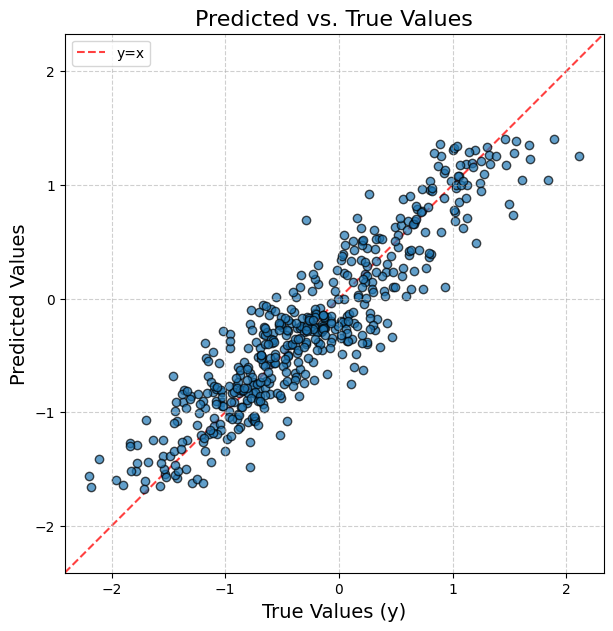

In [650]:
import matplotlib.pyplot as plt
import numpy as np

y_np = y.cpu().numpy()
# **** IMPORTANT: Get predictions at the locations of x ****
# Replace this with your actual prediction mechanism for x:
try:
    # E.g. y_pred_on_x = model.predict(x)['mean'].cpu().numpy() # Placeholder
    # Interpolate from existing grid prediction if direct prediction is unavailable
    y_pred_on_x = griddata(x_new.cpu().numpy(), ytrg['mean'].cpu().numpy(), x.cpu().numpy(), method='cubic')

    # --- Plot ---
    plt.figure(figsize=(7, 7))
    plt.scatter(y_np, y_pred_on_x, alpha=0.7, edgecolors='k')

    # Add y=x line for reference
    lims = [
        np.min([plt.xlim(), plt.ylim()]),  # min of both axes
        np.max([plt.xlim(), plt.ylim()]),  # max of both axes
    ]
    plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='y=x')
    plt.xlim(lims)
    plt.ylim(lims)

    plt.xlabel('True Values (y)', fontsize=14)
    plt.ylabel('Predicted Values', fontsize=14)
    plt.title('Predicted vs. True Values', fontsize=16)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

except Exception as e:
    print(f"Could not create Predicted vs True plot: {e}")

In [651]:
assert torch.allclose(ytrg['mean'], yhat_direct)
print("ytrg['mean'] and yhat_direct are the same")
assert torch.allclose(ytrg['var'], variance_direct)
print("ytrg['var'] and variance_direct are the same")


ytrg['mean'] and yhat_direct are the same
ytrg['var'] and variance_direct are the same
